# Bayesian analysis of the empirical saturation point (MC version)

This notebook provides an independent implementation of our saturation analysis using brute-force Monte Carlo sampling. It can be used to check and generalize our analysis using conjugate priors.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import emcee as mc
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import invwishart, multivariate_normal, multivariate_t
from modules.plot_helpers import plot_confregion_bivariate_t

To test the analysis, let's create some dummy data from the prior we have used before:

In [3]:
prior_params = {"mu": np.array([0.16, -15.9]),
                "Psi": np.array([[0.01**2, 0], [0, 0.32**2]]),
                "kappa": 1, "nu": 4}
np.random.seed(42)
tmp = multivariate_normal.rvs(mean=prior_params["mu"], cov=prior_params["Psi"], size=1000)
data = pd.DataFrame(data={"n0": tmp[:, 0], "E0": tmp[:, 1]})

Let's plot the prior quickly with confidence regions similar to $1\sigma$, $2\sigma$, and $3\sigma$ for a bivariate normal distribution: 

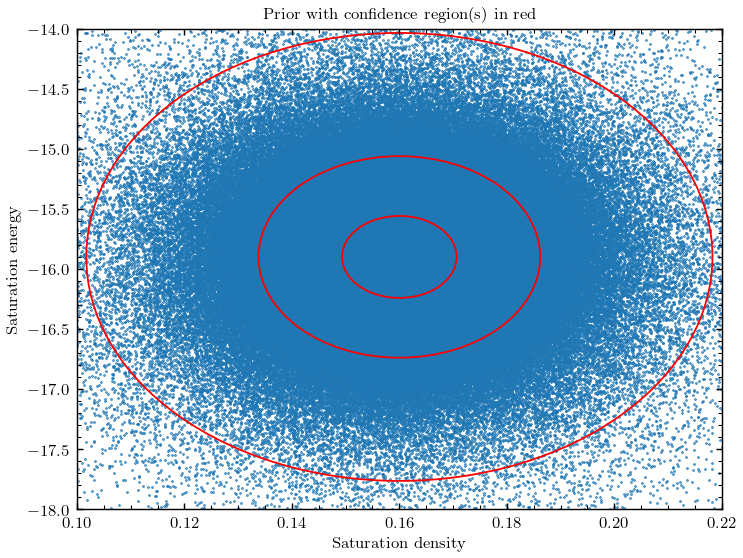

In [4]:
fig, ax = plt.subplots(1,1)
plot_confregion_bivariate_t(ax=ax, mu=prior_params["mu"], 
                            Sigma=prior_params["Psi"], 
                            nu=prior_params["nu"], 
                            alpha=list(range(1,4)), alpha_unit="normal_std", num_pts=1000000, 
                            plot_scatter=True, validate=False)
ax.set_title("Prior with confidence region(s) in red")
ax.set_xlim(0.10, 0.22)
ax.set_ylim(-18, -14)
ax.set_xlabel("Saturation density")
ax.set_ylabel("Saturation energy")
fig.savefig("prior_satpoint_conf_regions.png")

## Bayes' theorem

Our analysis is based on Bayes' theorem. We need to define the prior, posterior, and likelihood. We use the (natural) logarithms of these quantities. The variables we will do the inference for are agglomerated in the parameter vector $\theta = (\mu_0, \mu_1; \Sigma_{0,0}, \Sigma_{0,1}, \Sigma_{1,1})$. To test the implementation, we define the $\theta$ associated with the prior:

In [4]:
theta_prior = (prior_params["mu"][0], prior_params["mu"][1],
           prior_params["Psi"][0, 0], prior_params["Psi"][0, 1],
           prior_params["Psi"][1, 1])

In [5]:
@nb.jit(nopython=True, fastmath=True)
def validate_matrix(mat, raise_error=False, atol_sym=1e-08, atol_eval=1e-06):
    """
    Checks that the 2x2 matrix `mat` is symmetric and positive definite
    :param mat: 2x2 matrix
    :param raise_error: raise error if not symmetric and positive definite
    :param atol_sym: absolute tolerance used for comparison (symmetry)
    :param atol_eval: absolute tolerance used for comparison (positiveness)
    :return: returns boolean result of the validation
    """
    stat_sym = np.abs(mat[0,1]-mat[1,0]) < atol_sym
    #v, _ = np.linalg.eig(mat) # only `eig` supported by numba
    eigvals = 0.5 * (mat[0,0] - np.array([1., -1]) * np.sqrt(4.* mat[0,1]*mat[1,0] + (mat[0,0] - mat[1,1])**2) + mat[1,1])
    stat_pos_def = (eigvals > atol_eval).all()
    stat = stat_sym and stat_pos_def
    if not stat and raise_error:
        raise ValueError("Non-symmetric and/or non-positive-definite 2x2 matrix encountered.")
    else:
        return stat

In [6]:
@nb.jit(nopython=True)
def parse_theta_vec(theta):
    """
    converts the array/vector `theta` into a mean value and (symmetric) covariance matrix
    :param theta: encodes mean vector (first two components) and the (symmetric) covariance matrix (last 3 components);
    :return: mean vector, full covariance matrix
    """
    mu = np.array([theta[0], theta[1]])
    cov = np.array([[theta[2], theta[3]], [theta[3], theta[4]]])
     
    # One might think of using the Choleslky decomposition to enforce positive (semi-)definitess of the returned matrix
    ## cov[0,1]=0 # treat components as lower triangle matrix
    ## cov = cov @ cov.T # use Cholesky decomposition to ensure at at least positive semi-definiteness
    # but this causes issues with the MLE and MAP solvers below
    
    return mu, cov

In [7]:
def log_prior(theta):
    """
    computes the log pdf of our chosen prior distribution, the normal-inverse-Wishart distribution
    Note: we can't use here `numba` straightforwardly because it does not support the distribution functions; `numba-scipy` and `numba-stats` address this issue but the inverse Wishart distribution has not been implemented in these libraries
    :param theta: parameter vector
    :return: log pdf associated with the prior
    """
    mu, sigma = parse_theta_vec(theta)
    if not validate_matrix(sigma):
        return -np.inf
    log_norm = multivariate_normal.logpdf(x=mu, mean=prior_params["mu"], cov=sigma/prior_params["kappa"])
    log_invwishart = invwishart.logpdf(x=sigma, df=prior_params["nu"], scale=prior_params["Psi"])
    return log_norm + log_invwishart

In [8]:
import math
def fast_log_2D_norm_invwishart(mu, Sigma, delta, gamma, Psi, alpha):
    det_Sigma = -Sigma[0, 1] * Sigma[1, 0] + Sigma[0, 0] * Sigma[1, 1]
    det_Psi = -Psi[0, 1] * Psi[1, 0] + Psi[0, 0] * Psi[1, 1]
    Sigma_inv = np.array([[Sigma[1, 1], -Sigma[0, 1]], [-Sigma[1, 0], Sigma[0, 0]]]) / det_Sigma
    invwishart_term = np.trace(Psi @ Sigma_inv)
    diff = mu - delta
    normal_term = gamma * np.dot(diff, np.dot(Sigma_inv, diff))
    D = 2
    norm_term = D / 2 * np.log(gamma)
    norm_term += alpha / 2 * np.log(det_Psi)
    norm_term -= (alpha + D + 2) / 2 * np.log(det_Sigma)
    norm_term -= D / 2 * np.log(2. * np.pi)
    norm_term -= alpha * D / 2 * np.log(2)
    alpha_half = alpha / 2
    norm_term -= 0.5 * np.log(np.pi) + np.log(math.gamma(alpha_half)) + np.log(math.gamma(alpha_half - 0.5))
    return norm_term - 0.5 * (invwishart_term + normal_term)

# def log_prior(theta):
#     mu, sigma = parse_theta_vec(theta)
#     if not validate_matrix(sigma):
#         return -np.inf
#     return fast_log_2D_norm_invwishart(mu=mu, Sigma=sigma, delta=prior_params["mu"],
#                                        gamma=prior_params["kappa"], Psi=prior_params["Psi"], alpha=prior_params["nu"])

In [9]:
@nb.jit(nopython=True, fastmath=True)
def log_likelihood(theta, sat_data):
    """
    computes the logarithm of the likelihood function, the standard Chi-squared likelihood function
    :param theta: parameter vector
    :param sat_data: array (number of point, 2) containing the datasets for the saturation density and energy
    :return: logarithm of the likelihood function
    """
    mu, sigma = parse_theta_vec(theta)
    # exclude non-positive-definite covariance matrices
    if not validate_matrix(sigma):
        #print('covariance not valid')
        return -np.inf
    chi2 = 0.
    sigma_inv = np.linalg.inv(sigma)
    for row in sat_data:
        diff = (row - mu)
        chi2 += np.dot(diff, sigma_inv @ diff)
    return -0.5 * (chi2 + len(sat_data) * np.log(np.abs(np.linalg.det(sigma))))

In [10]:
def log_posterior(theta, sat_data):
    """
    computes the log posterior, which is in this particular case also the normal-inverse-Wishart distribution (conjugagy).
    :param theta: parameter vector
    :param sat_data: pandas dataframe containing the datasets for the saturation density and energy
    :return: log pdf associated with the posterior
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, sat_data)

## Testing our implementation

## Bayesian inference

### Determine initial walker position using MLE or MAP

We need to specify the initial position of the random walkers for Monte Carlo sampling. We use here either the MAP or MLE.

In [11]:
def get_initial_walker_pos(function=log_posterior, method="Nelder-Mead", return_theta=False, **kwargs):
    """
    finds the maximum of the argument `function`; to be used to determine either the maximum a posterior (MAP) or maximum likelihood estimation (MLE)
    :param function: either likelihood function or posterior or prior
    :param method: method used for optimization, see scipy documentation
    :param kwargs: options passed to the optimizer, see scipy documentation
    :param return_theta: boolean to request solution vector or (mu, cov)
    :return: mean value and covariance associated with the found maximum or found maximum (if return_theta)
    """
    nll = lambda *args: -function(*args)
    args = () if function == log_prior else (data.to_numpy(),)
    sol = minimize(nll, theta_prior, args=args, method=method, tol=1e-12, options=kwargs)
    mu, cov = parse_theta_vec(sol.x)
    if not validate_matrix(cov):
        raise ValueError("Covariance matrix not positive definite")
    return sol.x if return_theta else (mu, cov)

In [12]:
map_estimate = get_initial_walker_pos(function=log_posterior, method="Nelder-Mead", maxiter=10000000)
mle_estimate = get_initial_walker_pos(function=log_likelihood, method="SLSQP", maxiter=10000000)

We expect both the MAP and MLE to be close to the (input) prior, so let's compute the difference of the respective mean values and covariance matrices:

In [13]:
for lbl, est in (("map", map_estimate), ("mle", mle_estimate)):
    print(lbl)
    mu, cov = est
    print(mu-prior_params["mu"])
    print(cov-prior_params["Psi"])
    print("estimated covariance matrix checks out:", validate_matrix(cov))

map
[0.00056925 0.01060897]
[[ 2.19399125e-06  8.00464643e-06]
 [ 8.00464643e-06 -8.45639078e-03]]
estimated covariance matrix checks out: True
mle
[0.0005697  0.01061973]
[[ 2.90563271e-06  8.08717359e-06]
 [ 8.08717359e-06 -7.80745770e-03]]
estimated covariance matrix checks out: True


Since the prior is quite uninformed, the MLE and MAP are very close to each other, as expected.

### Monte Carlo sampling

We use the library `multiprocess` because `multiprocessing` has issues with Jupyter notebooks.

Warning: runtime might be several hours depending on the configuration.

In [173]:
def perturb_init_pos_walkers(init_pos, nwalkers, enforce_posdef=True, std_perturbation=1e-2, delta_mean=0.02):
    """
    creates initial positions of `nwalkers` by randomly perturbing a given (single) initial position `init_pos` 
    :param init_pos: datasets for saturation point
    :param nwalkers: number of walkers requested
    :param enforce_posdef: enforce that matrix component in the output is positive (semi-)definite (in addition to symmetric)
    :param std_perturbation: standard deviation of the perturbation
    :param delta_mean: mean value of the normal distribution (delta_mean, std_perturbation**2) for the minimum eigenvalues used to obtain the nearest pos. def. matrix in Frobenius norm
    :return: array of shape (nwalkers, len(init_pos)) containing the perturbed initial positions of the random walkers
    """
    # perturbation preserves symmetry but not definiteness of matrix `init_pos`
    # return array will be component-wise distributed as "Normal(mu=init_pos, sigma^2=std_perturbation)"
    ret = init_pos + std_perturbation * np.random.randn(nwalkers, len(init_pos)) 
    
    # make matrix encoded in `init_pos` (i.e., theta) positive (semi-)definite after perturbation,
    # by finding the nearest sym. pos. def. matrix in Frobenius norm
    # https://nhigham.com/2021/01/26/what-is-the-nearest-positive-semidefinite-matrix/ (based on Cheng & Higham, 1998)
    if enforce_posdef:
        triu_indices = np.triu_indices(2)
        for row in ret:
            mu, mat = parse_theta_vec(row)
            if not validate_matrix(mat): # leave walker alone if its matrix is already pos. def.
                v, w = np.linalg.eig(M)
                delta = np.abs(delta_mean+std_perturbation * np.random.randn())
                cov = w @ np.diag(np.clip(v, a_min=delta, a_max=None)) @ w.T  # increase eigenvalues if necessary
                validate_matrix(cov, raise_error=True)
                row[2:] = cov[triu_indices]
    return ret
# perturb_init_pos_walkers([1,1,2,3,4], 5)
# perturb_init_pos_walkers([1,1,1,0,0.001], 5, enforce_posdef=True)

In [175]:
import multiprocess as mp
def run_mcmc_sampler(sat_data, nwalkers=1000, nsteps=50, nsteps_burn=50, log_prob_fn=log_posterior, num_threads=4, offset=1e-2):
    """
    samples the function provided by `log_prob_fn`
    :param sat_data: datasets for saturation point
    :param nwalkers: number of walkers
    :param nsteps: number of MCMC steps after burn-in phase
    :param nsteps_burn: number of MCMC steps used for burn in
    :param log_prob_fn: function to be sampled
    :param num_threads: number of threads to be used
    :param offset: magnitude of random displacement from walkers' initial positions
    :return: sampler, pos, prob, state (see emcee documentation)
    """
    if log_prob_fn == log_likelihood:
        init_pos = get_initial_walker_pos(function=log_prob_fn, method="SLSQP",
        return_theta=True)
    else:
        init_pos = get_initial_walker_pos(function=log_posterior, method="Nelder-Mead", return_theta=True)

    if num_threads is None:
        num_threads = mp.cpu_count()

    ndim = len(init_pos)
    args = None if log_prob_fn == log_prior else (sat_data.to_numpy(),)
    with mp.Pool(num_threads) as pool:
        # for multiprocessing with emcee, see https://emcee.readthedocs.io/en/stable/tutorials/parallel/#multiprocessing
        # https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
        sampler = mc.EnsembleSampler(nwalkers=nwalkers, ndim=ndim,
                                     log_prob_fn=log_prob_fn, args=args, pool=pool)
        
        # let each walker start at a slightly different initial position (random perturbation)
        pos = perturb_init_pos_walkers(init_pos, nwalkers, enforce_posdef=True, std_perturbation=offset)
    
        if nsteps_burn > 0:
            pos, _, _ = sampler.run_mcmc(initial_state=pos, nsteps=nsteps_burn, progress=True)
            sampler.reset()
        pos, prob, state = sampler.run_mcmc(initial_state=pos, nsteps=nsteps, progress=True)
    return sampler, pos, prob, state

### Testing

We test here that the implemented distribution functions match the analytically known results for the mean values.

We begin the testing with the prior distribution:

In [176]:
sampler, pos, prob, state = run_mcmc_sampler(sat_data=data, log_prob_fn=log_prior, nwalkers=10, nsteps=500000, nsteps_burn=50000)
samples_prior = sampler.flatchain
# sampler.chain[:,:,4].mean(axis=1)
samples_prior.mean(axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [28:25<00:00, 293.17it/s]


array([ 1.60000492e-01, -1.58988143e+01,  1.02293151e-04,  1.04765338e-04,
        1.00443071e-01])

The expected covariance of the two components of the mean vector is $\Psi / \kappa$.

In [177]:
#samples#.mean(axis=0)
expected = prior_params["Psi"]/prior_params["kappa"]
got = np.cov(samples_prior[:,0], samples_prior[:,1])
got - expected

array([[ 9.62370832e-06,  2.22310134e-04],
       [ 2.22310134e-04, -7.79174304e-06]])

Our expectation for the mean values from the prior distribution is a follows:
$$
E(\mu) = \mu_0 \;, \qquad
E(\Sigma) = \frac{\Sigma}{\nu - p -1} \quad \mathrm{for} \; \nu > p + 1
$$
with $p=2$ being associated with rank of the $p \times p$ covariance matrix $\Sigma$. Hence, the mean value of the covariance matrix is _undefined_ in the original case we considered, $\nu_0 = 3$.

In [178]:
def mean_val_inv_wish(Psi, nu):
    """
    computes the mean value of the Inverse-Wishart distribution, see https://en.wikipedia.org/wiki/Inverse-Wishart_distribution
    :param Lambda: covariance matrix
    :param nu: degree of freedom
    :return: mean value of the associated Inverse-Wishart distribution
    """
    p = len(Psi)
    mean = Psi / (nu - p - 1) if nu > p+1 else np.inf
    mode = Psi / (nu + p + 1)

    tmp = nu - p - 1
    cov = np.zeros((4,4))
    for i in range(2):
        for j in range(2):
            ii = i + 2*j
            for k in range(2):
                for l in range(2):
                    jj = k + 2*l
                    cov[ii, jj] = 2 * Psi[i,j]*Psi[k,l] + tmp * (Psi[i,k]*Psi[j,l] + Psi[i,l]*Psi[k,j])
                    # taken from https://en.wikipedia.org/wiki/Inverse-Wishart_distribution#Moments
    cov = cov / (nu-p)*tmp**2*(nu-p-3)
    print("covariance matrix", cov)
    return mean, mode

In [179]:
mean_mean_vec = prior_params["mu"]
mean_cov, mode_cov = mean_val_inv_wish(prior_params["Psi"], prior_params["nu"])
print(f"mean of mean vector: {mean_mean_vec}")
print(f"mean of covariance matrix: {mean_cov}")
print(f"mode of covariance matrix: {mode_cov}")

covariance matrix [[-2.000000e-08 -0.000000e+00 -0.000000e+00 -1.024000e-05]
 [-0.000000e+00 -5.120000e-06 -5.120000e-06 -0.000000e+00]
 [-0.000000e+00 -5.120000e-06 -5.120000e-06 -0.000000e+00]
 [-1.024000e-05 -0.000000e+00 -0.000000e+00 -2.097152e-02]]
mean of mean vector: [  0.16 -15.9 ]
mean of covariance matrix: [[1.000e-04 0.000e+00]
 [0.000e+00 1.024e-01]]
mode of covariance matrix: [[1.42857143e-05 0.00000000e+00]
 [0.00000000e+00 1.46285714e-02]]


The mean vector and covariance matrix seem to be in agreement with the ones from the prior.
Let's investigate the mode of the prior, which seems slightly off. Why? Because the prior is relatively flat?

In [180]:
get_initial_walker_pos(function=log_prior, method="Nelder-Mead", maxiter=10000000)

(array([  0.16, -15.9 ]),
 array([[ 1.24999999e-05, -1.51130086e-11],
        [-1.51130086e-11,  1.27999999e-02]]))

In [181]:
np.cov((samples_prior[:,2], samples_prior[:,3], samples_prior[:,4]))

array([[3.42580708e-07, 3.87696399e-06, 1.18984234e-04],
       [3.87696399e-06, 1.24242710e-04, 3.40373379e-03],
       [1.18984234e-04, 3.40373379e-03, 3.42961096e-01]])

Why is the last component so large?

Now, let's investigate the predictive $y$ distribution:

In [182]:
def predictive_y(samples, size=1):
    y_samples = []
    for row in samples:
        mu, Sigma = parse_theta_vec(row)
        y_samples.append(multivariate_normal.rvs(mean=mu, cov=Sigma, size=size))
    return np.array(y_samples)
pred_y_samples = predictive_y(samples_prior)

For the mean value of the prior predictive $y$, which is the Student's $t$-distribution, we expect just the prior mean vector. We find agreement with the expectation.

In [183]:
pred_y_samples.mean(axis=0)

array([  0.16000501, -15.89869752])

We expect
\begin{equation}
    P(\boldsymbol{y}^*| \mathcal{D}) \sim t_{\nu_n -p +1} \Big( \boldsymbol{\mu_n}, \frac{\boldsymbol{\Lambda_n}(k_n+1)}{k_n(\nu_n-p+1)} \Big),
\end{equation}
so the mean vector is just the mean vector of the prior and the variance
$$
\frac{\nu'_n}{\nu'_n-2} \boldsymbol{\Sigma}' =  \frac{\boldsymbol{\Lambda_n}(k_n+1)}{k_n(\nu_n-p-1)}
$$

In [184]:
def variance_multivar_t(nu, Sigma):
    # see https://en.wikipedia.org/wiki/Multivariate_t-distribution
    return nu/(nu-2) * Sigma if nu > 2 else np.inf
variance_multivar_t(prior_params["nu"]-2+1,
                    prior_params["Psi"] * (prior_params["kappa"]+1)/(prior_params["kappa"]*(prior_params["nu"]-2+1)))

array([[2.000e-04, 0.000e+00],
       [0.000e+00, 2.048e-01]])

In [185]:
np.cov(pred_y_samples[:,0], pred_y_samples[:,1])

array([[0.00021284, 0.0003396 ],
       [0.0003396 , 0.20343483]])

It looks like the variances agree (although not perfectly). Why? Do we just need more sampling points? Prior too uninformed?

Next, let's consider the posterior distribution:

In [186]:
sampler, pos, prob, state = run_mcmc_sampler(sat_data=data, log_prob_fn=log_posterior, nwalkers=10, nsteps=300000, nsteps_burn=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [19:46<00:00, 252.86it/s]


In [187]:
samples_posterior = sampler.flatchain
samples_posterior.mean(axis=0)

array([ 1.60565342e-01, -1.58893291e+01,  1.02896541e-04,  8.37279659e-06,
        9.45590092e-02])

Our expectation for the mean values from the updated prior distribution due to conjugacy is as follows (see our manuscript for the equations):

In [188]:
ret = dict()
ret["kappa"] = prior_params["kappa"] + len(data)
ret["nu"] = prior_params["nu"] + len(data)
ret["sample_mean"] = data.mean().to_numpy()
ret["mu"] = np.array([prior_params["kappa"], len(data)]) @ np.array([prior_params["mu"], ret["sample_mean"]]) / ret["kappa"]
diff = ret["sample_mean"] - prior_params["mu"]
tmp = data - ret["sample_mean"]
ret["sum_squared_dev"] = np.sum([np.outer(row.to_numpy(), row.to_numpy()) for irow, row in tmp.iterrows()], axis=0)
ret["Psi"] = prior_params["Psi"] + ret["sum_squared_dev"] + (prior_params["kappa"] * len(data) / ret["kappa"]) * np.outer(diff, diff)
print("expected mean vector", ret["mu"])
print("expected covariance matrix:", mean_val_inv_wish(ret["Psi"], ret["nu"])[0])

expected mean vector [  0.16056925 -15.88939104]
covariance matrix [[2.12439583e+07 1.66399881e+06 1.66399881e+06 1.96201072e+07]
 [1.66399881e+06 9.75475991e+09 9.75475991e+09 1.52965993e+09]
 [1.66399881e+06 9.75475991e+09 9.75475991e+09 1.52965993e+09]
 [1.96201072e+07 1.52965993e+09 1.52965993e+09 1.79522629e+13]]
expected covariance matrix: [[1.02908636e-04 8.06063757e-06]
 [8.06063757e-06 9.46005591e-02]]


Note that $\Sigma_{1,1}$ (lower right) is large \[Note that the matrix elements above include the denominator from the mean value\]. Does that make sense? But keep in mind that $\Sigma/\kappa_n$ will be used as covariance matrix in the normal distribution (of the Normal-Inverse Wishart)---but not in the inverse Wishart distribution.

The mean vector looks like a match. Except for the $\Sigma_{11}$ component, it does not look like a good match for $\Sigma$. Here are the ratios of the matrix elements:

In [189]:
m, c = parse_theta_vec(samples_posterior.mean(axis=0))
c/mean_val_inv_wish(ret["Psi"], ret["nu"])[0]

covariance matrix [[2.12439583e+07 1.66399881e+06 1.66399881e+06 1.96201072e+07]
 [1.66399881e+06 9.75475991e+09 9.75475991e+09 1.52965993e+09]
 [1.66399881e+06 9.75475991e+09 9.75475991e+09 1.52965993e+09]
 [1.96201072e+07 1.52965993e+09 1.52965993e+09 1.79522629e+13]]


array([[0.99988247, 1.03872634],
       [1.03872634, 0.99956079]])

In [190]:
#samples#.mean(axis=0)
expected = ret["Psi"]/ret["kappa"]
got = np.cov(samples_posterior[:,0], samples_posterior[:,1])
got - expected

array([[-1.02805723e-04, -8.05989519e-06],
       [-8.05989519e-06, -9.45061716e-02]])

In [191]:
mean_mean_vec = ret["mu"]
mean_cov, mode_cov = mean_val_inv_wish(ret["Psi"], ret["nu"])
print(f"mean of mean vector: {mean_mean_vec}")
print(f"mean of covariance matrix: {mean_cov}")
print(f"mode of covariance matrix: {mode_cov}")

covariance matrix [[2.12439583e+07 1.66399881e+06 1.66399881e+06 1.96201072e+07]
 [1.66399881e+06 9.75475991e+09 9.75475991e+09 1.52965993e+09]
 [1.66399881e+06 9.75475991e+09 9.75475991e+09 1.52965993e+09]
 [1.96201072e+07 1.52965993e+09 1.52965993e+09 1.79522629e+13]]
mean of mean vector: [  0.16056925 -15.88939104]
mean of covariance matrix: [[1.02908636e-04 8.06063757e-06]
 [8.06063757e-06 9.46005591e-02]]
mode of covariance matrix: [[1.02295477e-04 8.01260993e-06]
 [8.01260993e-06 9.40369013e-02]]


In [192]:
get_initial_walker_pos(function=log_posterior, method="Nelder-Mead", maxiter=10000000)

(array([  0.16056925, -15.88939103]),
 array([[1.02193991e-04, 8.00464643e-06],
        [8.00464643e-06, 9.39436092e-02]]))

In [193]:
np.cov((samples_posterior[:, 2], samples_posterior[:, 3], samples_posterior[:, 4]))

array([[ 2.12397805e-11,  1.59501180e-12, -6.21551429e-13],
       [ 1.59501180e-12,  9.69144374e-09,  5.09742817e-10],
       [-6.21551429e-13,  5.09742817e-10,  1.78883946e-05]])

In [194]:
pred_y_samples = predictive_y(samples_posterior)
pred_y_samples.mean(axis=0) - ret["mu"]

array([-5.17259090e-06,  1.34311284e-04])

In [195]:
variance_multivar_t(ret["nu"] - 2 + 1,
                    ret["Psi"] * (ret["kappa"] + 1) / (ret["kappa"] * (ret["nu"] - 2 + 1)))

array([[1.03011442e-04, 8.06869015e-06],
       [8.06869015e-06, 9.46950651e-02]])

In [196]:
np.cov(pred_y_samples[:, 0], pred_y_samples[:, 1])

array([[1.03064271e-04, 1.01612901e-05],
       [1.01612901e-05, 9.46021699e-02]])

## Useful links

* [Covariances and Pearson correlation](https://cxwangyi.wordpress.com/2010/08/29/pearson-correlation-coefficient-covariance-matrix-and-linear-dependency/)
* [emcee tutorial for fitting (1)](https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html)
* [emcee tutorial for fitting (2)](https://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html)
* [emcee tutorial for fitting (3)](https://emcee.readthedocs.io/en/stable/tutorials/line/)
* [multivariate normal distribution](https://online.stat.psu.edu/stat505/book/export/html/636)
* [A Note on Wishart and Inverse Wishart Priors for Covariance Matrix](https://jbds.isdsa.org/public/journals/1/html/v1n2/p2/)